In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from datetime import datetime
from meteostat import Point, Daily, Hourly

In [2]:
# Load data
df_firecalls=pd.read_csv('C:/Users/tp3/Downloads/niologic/Seattle_Real_Time_Fire_911_Calls.csv',sep=",")

In [3]:
# Get Weather data from meteostat from 2016
def load_weather_data(latitude,longitude,elevation):
    station = Point(latitude,longitude,elevation) 
    start = datetime(2016, 1, 1)
    end = datetime(2022, 10, 1)
    df = Hourly(station, start, end)
    df = df.fetch()
    
    return df

# # longitude, latitude and elevation of seattle
# seattle = Point(47.61,-122.33,57) 

In [4]:
df_weather=load_weather_data(47.61,-122.33,57)

# Data Preprocessing

In [5]:
# first data is the 911 call data and the second one is the weather data 
def Preprocessing(df1,df2):
    # drop non-relevant columns from df1
    df1=df1.drop(['Report Location','Incident Number','Latitude','Longitude','Address','Type'], axis=1)
    df1['Datetime']=pd.to_datetime(df1['Datetime'], format="%m/%d/%Y %I:%M:%S %p")
    df1['Datetime']=df1['Datetime'].dt.strftime('%Y-%m-%d %H')
    #consider data from 2016
    df1=df1[df1['Datetime']>='2016-01-01']
    df1.sort_values(by='Datetime', inplace=True)
    
    # calculate calls per hour
    Calls=pd.DataFrame(df1.groupby('Datetime')['Datetime'].count()).rename(columns = {'Datetime':'calls_hour'}).reset_index()
    #splitting datetime column into multiple column so that data information at individual level can be processed
    #by model
    Calls['year']=pd.DatetimeIndex(Calls['Datetime']).year
    Calls['month']=pd.DatetimeIndex(Calls['Datetime']).month
    Calls['dayofmonth']=pd.DatetimeIndex(Calls['Datetime']).day
    Calls['hour']=pd.DatetimeIndex(Calls['Datetime']).hour
    Calls['dayofyear']=pd.DatetimeIndex(Calls['Datetime']).dayofyear
    Calls['dayofweek']=pd.DatetimeIndex(Calls['Datetime']).dayofweek

    # imputation of missing values in the weather dataframe
    df2['pres'].interpolate(method='linear', inplace=True)
    df2['wdir'].interpolate(method='linear', inplace=True)
    df2['coco'].interpolate(method='bfill', inplace=True)
    df2=df2.reset_index()
    df2['Datetime']=df2['time'].dt.strftime('%Y-%m-%d %H')
    df2=df2.drop(['time','prcp','snow','wpgt','tsun'], axis=1)
    
    # merge two dataframe to have our cleaned final data
    df=pd.merge(Calls,df2, how="inner", on=["Datetime"])
    
    return df

In [6]:
df=Preprocessing(df_firecalls,df_weather)

# Train Test Split

In [7]:
def get_train_test(df):
    
    df_train=df[df['Datetime']<'2022-08-01'] # training set
    df_test=df[df['Datetime']>='2022-08-01'] # test set (last 2 months)

    # add another column which holds the number of calls of previous the hour
    df_train = df_train.assign(previous_hour_calls =  df_train['calls_hour'].shift(1))
    df_train = df_train.dropna()

    X_train=df_train.drop(['Datetime','calls_hour','year'],axis=1)
    y_train=df_train['calls_hour']

    X_test=df_test.drop(['Datetime','calls_hour','year'],axis=1)
    y_test=df_test['calls_hour']
    
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = get_train_test(df)

# Model Training

In [9]:
def train_model(X_train, y_train):
#     model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators = 1000)
#     model.fit(X_train, y_train)

    model=AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    return model

# Model Testing

In [10]:
## "previous_hour_calls" is one of the generated feaute which tells number of the calls in previous hour
## test data does not contain this "previous_hour_calls" feature
## Therefore it has to be calculated on the go. 
## I used calls of the last training example to set "previous_hour_calls" for the first test example
## For later test example we used prediction of the previous test example to set "previous_hour_calls"

def test_model(model,X_test,y_test,y_train):
    predictions = []
    originals = []
    pred = int(y_train.iloc[-1]) # calls of the last training example

    for i in range(len(X_test)):
        x = X_test[i:i+1]
        x = x.assign(previous_hour_calls = pred) # update "previous_hour_calls" for current test example
        y = y_test[i:i+1]
        pred = model.predict(x)
        predictions.append(round(pred[0])) # model returns list of one element
        originals.append(int(y.values))
        
    return predictions, originals    

In [11]:
def plotting(predictions, originals):
    preds_day = np.add.reduceat(predictions, np.arange(0, len(predictions), 24)) # call prediction per day
    preds_week = np.add.reduceat(preds_day, np.arange(0, len(preds_day), 7)) # call prediction per week
    preds_month = np.add.reduceat(preds_day, np.arange(0, len(preds_day), 30)) # call prediction per month

    originals_day = np.add.reduceat(originals, np.arange(0, len(originals), 24)) # call per day 
    originals_week = np.add.reduceat(originals_day, np.arange(0, len(originals_day), 7)) # call per week
    originals_month = np.add.reduceat(originals_day, np.arange(0, len(originals_day), 30)) # call per month
    
    print("RMSE per hour",mean_squared_error(originals, predictions, squared=False))
    print("RMSE per day",mean_squared_error(preds_day, originals_day, squared=False))
    print("RMSE per week",mean_squared_error(preds_week, originals_week, squared=False))
    print("RMSE per month",mean_squared_error(preds_month, originals_month, squared=False))

    print("MAE per hour",mean_absolute_error(originals, predictions))
    print("MAE per day",mean_absolute_error(preds_day, originals_day))
    print("MAE per week",mean_absolute_error(preds_week, originals_week))
    print("MAE per month",mean_absolute_error(preds_month, originals_month))
    
    plt.figure(figsize=(15,5))
    plt.title("prediction vs target hourly")
    plt.plot(originals , label='target')
    plt.plot(predictions, label='prediction')
    plt.legend()

    plt.figure(figsize=(15,5))
    plt.title("prediction vs target daily")
    plt.plot(originals_day , label='target')
    plt.plot(preds_day, label='prediction')
    plt.legend()

    plt.figure(figsize=(15,5))
    plt.title("prediction vs target weekly")
    plt.plot(originals_week , label='target')
    plt.plot(preds_week, label='prediction')
    plt.legend()

    plt.figure(figsize=(15,5))
    plt.title("prediction vs target monthly")
    plt.plot(originals_month , label='target')
    plt.plot(preds_month, label='prediction')
    plt.legend()
    
    

In [12]:
model=train_model(X_train, y_train)

In [13]:
predictions, originals=test_model(model,X_test,y_test,y_train)

RMSE per hour 4.752006940848289
RMSE per day 32.96332272634678
RMSE per week 136.3084736911099
RMSE per month 398.12979458128143
MAE per hour 3.81160409556314
MAE per day 27.06451612903226
MAE per week 123.55555555555556
MAE per month 329.3333333333333


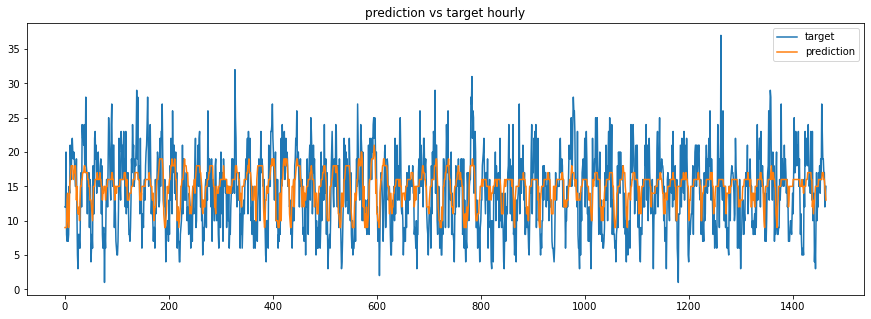

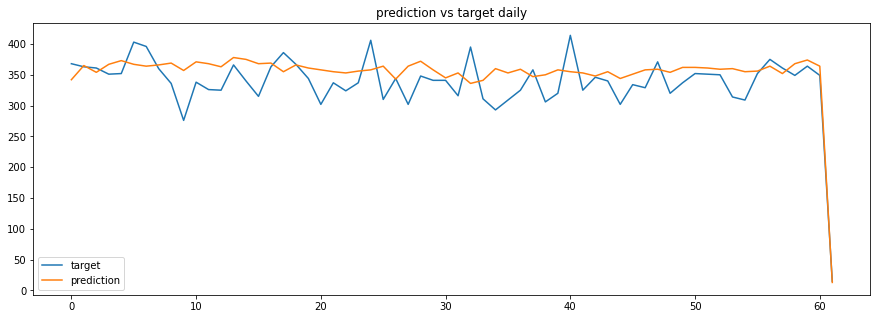

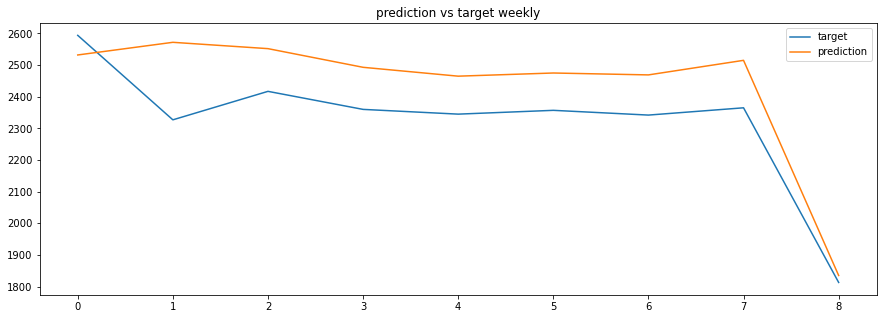

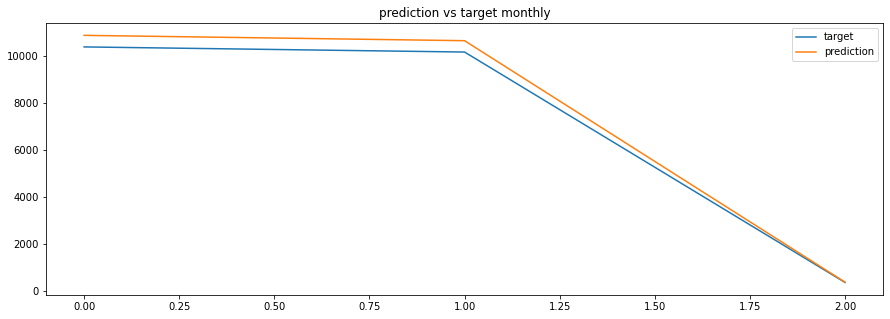

In [14]:
plotting(predictions, originals)